In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import operator
from sklearn.preprocessing import StandardScaler

### Reading in data

In [2]:
data = np.load("data/predict_iri_data3.npy")
iri = data[:, -1]
scaler = StandardScaler(with_mean = False)
scaler.fit(data[:, :-1])
data = scaler.transform(data[:, :-1])
print(data.shape)
df = pd.DataFrame(data, columns=["acc_mean", "acc_var", "acc_min", "acc_max", "acc_range"])
df['IRI'] = iri
df.head()

(3000, 5)


,acc_mean,acc_var,acc_min,acc_max,acc_range,IRI
0,0.201782,0.521093,-0.970075,0.965242,1.065677,4.466933
1,1.667860,1.450296,-2.002355,1.690830,2.030938,7.333653
2,-0.037131,0.684477,-1.271801,1.594334,1.581178,4.671080
3,1.274430,0.606822,-1.081521,2.166941,1.798536,4.138502
4,0.258861,0.116244,-0.654966,0.624600,0.704346,1.969320


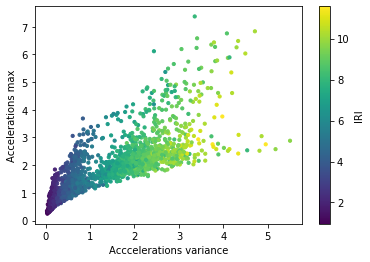

In [3]:
plt.scatter(df['acc_var'], df['acc_max'], c = df['IRI'], s = 10)
cb = plt.colorbar()
cb.set_label('IRI')
plt.xlabel("Acccelerations variance")
plt.ylabel("Accelerations max")
plt.show()

### Learning trendline

In [4]:
def square_root_features(X):
    new = np.hstack((np.ones_like(X), X, np.sqrt(X)))
    return new

In [5]:
X = np.concatenate((df['acc_var'].values[:, np.newaxis], df['acc_max'].values[:, np.newaxis]), axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, df['IRI'], test_size=0.3, random_state=42)

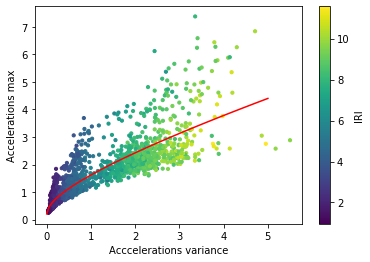

In [6]:
acc_var = X_train[:, 0][:, np.newaxis]
acc_max = X_train[:, 1][:, np.newaxis]

acc_var_root = square_root_features(acc_var)

model = LinearRegression()
model.fit(acc_var_root, acc_max)

line_x = np.linspace(0, 5, 100)[:, np.newaxis]
line_y = model.predict(square_root_features(line_x))

plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 10)
plt.plot(line_x, line_y, c = 'red')
cb = plt.colorbar()
cb.set_label('IRI')
plt.xlabel("Acccelerations variance")
plt.ylabel("Accelerations max")
plt.show()

### Learning IRI values

In [7]:
def project_on_curve(X, neighbors, iris):
    
    # Finding closest neighbors
    closest_neighbors = np.zeros_like(X)
    for i in range(len(X)):
        min_distance = np.inf
        for neighbor in neighbors:
            distance = np.linalg.norm(neighbor-X[i])
            if distance < min_distance:
                min_distance = distance
                closest_neighbors[i] = neighbor
    
    # Making a default dict with empty lists
    curve_iri = {}
    for n in neighbors:
        curve_iri[tuple(n)] = []
    
    # The lists are filled up with the iri values of the original points
    for cn, iri in zip(closest_neighbors, iris):
        curve_iri[tuple(cn)].append(iri)
    
    # Taking the average of the lists
    # If there's an empty list it defaults to 0
    curve_points = []
    average_curve_iri = []
    for neighbor, irilist in curve_iri.items():
        curve_points.append(neighbor)
        if irilist == []:
            average_curve_iri.append(0)
        else:
            average_curve_iri.append(np.mean(irilist))
    
    return curve_points, average_curve_iri


def optimise_iri_curve(points, points_value, smoothing):
            
    # Ordering points
    sorted_data = np.concatenate((points, np.array(points_value)[:, np.newaxis]), axis = 1)
    sorted_data = np.array(sorted(sorted_data, key = lambda x: x[0]))
    
    # Interpolating 
    for i in range(1, len(sorted_data)-1):
        if sorted_data[i][2] == 0:
            sorted_data[i][2] = sorted_data[i-1][2]
    
    #Smoothing
    for i in range(smoothing):
        for i in range(1, len(sorted_data)-1):
            sorted_data[i][2] = (sorted_data[i-1][2] + sorted_data[i +1][2])/2
        
    return sorted_data[:, :-1], sorted_data[:, -1]
        
    

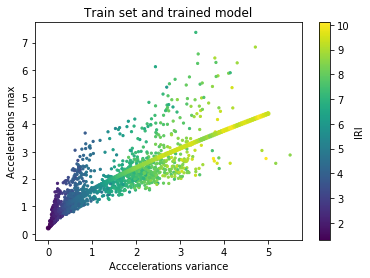

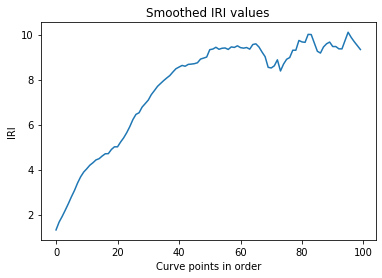

In [8]:
smoothing = 2
curve = np.concatenate((line_x, line_y), axis = 1)
curve_points, curve_iri = project_on_curve(X_train, curve, y_train)
curve_points, curve_iri_smoothed = optimise_iri_curve(curve_points, curve_iri, smoothing)

acc_var = X_train[:, 0][:, np.newaxis]
acc_max = X_train[:, 1][:, np.newaxis]

acc_var_root = square_root_features(acc_var)

model = LinearRegression()
model.fit(acc_var_root, acc_max)

line_x = np.linspace(0, 5, 100)[:, np.newaxis]
line_y = model.predict(square_root_features(line_x))


plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 5)
#plt.plot(line_x, line_y, c = 'red')
plt.scatter(curve_points[:, 0], curve_points[:, 1], c = curve_iri_smoothed, s = 15)
cb = plt.colorbar()
cb.set_label('IRI')
plt.xlabel("Acccelerations variance")
plt.ylabel("Accelerations max")
plt.title("Train set and trained model")
plt.show()

plt.plot(curve_iri_smoothed)
plt.title("Smoothed IRI values")
plt.ylabel("IRI")
plt.xlabel("Curve points in order")
plt.show()

### Predictions on the test set

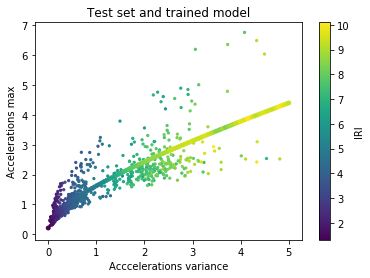

In [9]:
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, s = 5)
#plt.plot(line_x, line_y, c = 'red')
plt.scatter(curve_points[:, 0], curve_points[:, 1], c = curve_iri_smoothed, s = 15)
cb = plt.colorbar()
cb.set_label('IRI')
plt.xlabel("Acccelerations variance")
plt.ylabel("Accelerations max")
plt.title("Test set and trained model")
plt.show()

In [10]:
def predict(test_set, curve_points, curve_iri):
    predictions = np.zeros(len(test_set))
    for i in range(len(test_set)):
        min_distance = np.inf
        for j in range(len(curve_points)):
            distance = np.linalg.norm(curve_points[j]-test_set[i])
            if distance < min_distance:
                min_distance = distance
                predictions[i] = curve_iri[j]
    
    return predictions

In [11]:
preds = predict(X_test, curve_points, curve_iri_smoothed)
mean_squared_error(preds, y_test)

0.5093709957645325

### Experimenting with smoothing rates

In [12]:
for smoothing in range(10):
    curve = np.concatenate((line_x, line_y), axis = 1)
    curve_points, curve_iri = project_on_curve(X_train, curve, y_train)
    curve_points, curve_iri_smoothed = optimise_iri_curve(curve_points, curve_iri, smoothing)
    preds = predict(X_test, curve_points, curve_iri_smoothed)
    rmse = np.sqrt(mean_squared_error(preds, y_test))
    print("Smoothing is {} and RMSE is {}".format(smoothing, rmse))


Smoothing is 0 and RMSE is 0.731851437265535
Smoothing is 1 and RMSE is 0.7133407024400279
Smoothing is 2 and RMSE is 0.7137023159304813
Smoothing is 3 and RMSE is 0.7150302364737403
Smoothing is 4 and RMSE is 0.7159090889579588
Smoothing is 5 and RMSE is 0.7168700908991995
Smoothing is 6 and RMSE is 0.7179063425582719
Smoothing is 7 and RMSE is 0.7190869185125809
Smoothing is 8 and RMSE is 0.7204245375558285
Smoothing is 9 and RMSE is 0.7219417838956367


### RMSE is lower for low IRI values

In [61]:
X_test_small_iri = []
y_test_small_iri = []

treshold = 2
y_test = y_test[:, np.newaxis]
for i in range(len(y_test)):
    if y_test[i] < treshold:
        X_test_small_iri.append(X_test[i])
        y_test_small_iri.append(y_test[i])

In [62]:
curve = np.concatenate((line_x, line_y), axis = 1)
curve_points, curve_iri = project_on_curve(X_train, curve, y_train)
curve_points, curve_iri_smoothed = optimise_iri_curve(curve_points, curve_iri, smoothing = 1)
preds_small = predict(X_test_small_iri, curve_points, curve_iri_smoothed)
y_test_small_iri = np.reshape(y_test_small_iri, newshape=(len(y_test_small_iri), 1))
print("Where true IRI is less than {}, RMSE is {}".format(treshold,
    np.sqrt(mean_squared_error(preds_small, y_test_small_iri))))

Where true IRI is less than 2, RMSE is 0.5354445308320492


### And higher for high IRI

In [63]:
X_test_large_iri = []
y_test_large_iri = []

treshold = 5
y_test = y_test[:, np.newaxis]
for i in range(len(y_test)):
    if y_test[i] > treshold:
        X_test_large_iri.append(X_test[i])
        y_test_large_iri.append(y_test[i])

In [65]:
curve = np.concatenate((line_x, line_y), axis = 1)
curve_points, curve_iri = project_on_curve(X_train, curve, y_train)
curve_points, curve_iri_smoothed = optimise_iri_curve(curve_points, curve_iri, smoothing = 1)
preds_large = predict(X_test_large_iri, curve_points, curve_iri_smoothed)
y_test_large_iri = np.reshape(y_test_large_iri, newshape=(len(y_test_large_iri), 1))
print("Where true IRI is higher than  {}, RMSE is {}".format(treshold,
    np.sqrt(mean_squared_error(preds_large, y_test_large_iri))))

Where true IRI is higher than  5, RMSE is 0.9754333661264427


### Experimenting with no. of neighbors

In [13]:
acc_var = X_train[:, 0][:, np.newaxis]
acc_max = X_train[:, 1][:, np.newaxis]
acc_var_root = square_root_features(acc_var)
model = LinearRegression()
model.fit(acc_var_root, acc_max)


for no_neighbors in range(100, 500, 50):
    line_x = np.linspace(0, 5, no_neighbors)[:, np.newaxis]
    line_y = model.predict(square_root_features(line_x))
    
    curve = np.concatenate((line_x, line_y), axis = 1)
    curve_points, curve_iri = project_on_curve(X_train, curve, y_train)
    curve_points, curve_iri_smoothed = optimise_iri_curve(curve_points, curve_iri, smoothing = 1)
    preds = predict(X_test, curve_points, curve_iri_smoothed)
    rmse = np.sqrt(mean_squared_error(preds, y_test))
    print("Number of neighbors is {} and RMSE is {}".format(no_neighbors, rmse))
    

Number of neighbors is 100 and RMSE is 0.7133407024400279
Number of neighbors is 150 and RMSE is 0.7024027279538545
Number of neighbors is 200 and RMSE is 0.7111711313818198
Number of neighbors is 250 and RMSE is 0.7223318620475736
Number of neighbors is 300 and RMSE is 0.7242011045492857
Number of neighbors is 350 and RMSE is 0.7397923539846465
Number of neighbors is 400 and RMSE is 0.7388979434308995
Number of neighbors is 450 and RMSE is 0.7536157563018677
